In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_10 共8个任务 

### 一、 Ecoli 内部交叉验证

#### 1.二分类

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/peaks_0.5_5.csv', t = False)
train_Y = np.zeros((992,2))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,816):                                           #Treated 816例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (816,992):                                         #Untreated 176例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=9, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_ecoli_0.5.mp')

2024-01-02 18:32:29,206 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 18:32:29,215 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 106/106 [00:00<00:00, 722.83it/s]


2024-01-02 18:32:30,113 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 18:32:34,004 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 18:32:34,025 - INFO - [bidd-aggmap] - Finished


In [5]:
mp = load('/mnt/lzyt/SmallSamples/data10/aggmap/aggmap_ecoli_0.5.mp')

In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 992/992 [00:04<00:00, 239.28it/s] 


Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


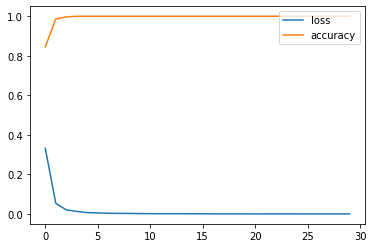

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


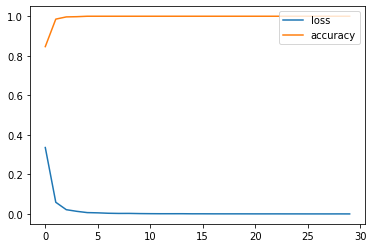

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


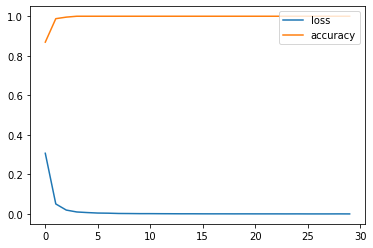

Auc =  0.9705882352941176
Acc =  0.98989898989899
f1_score =  0.98989898989899
average_precision =  0.98989898989899
recall_score =  0.98989898989899


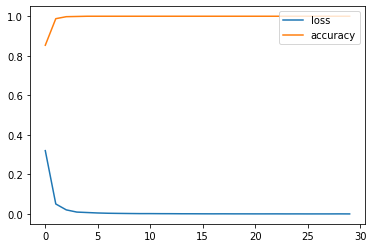

Auc =  0.9411764705882353
Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


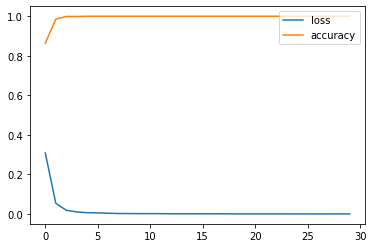

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


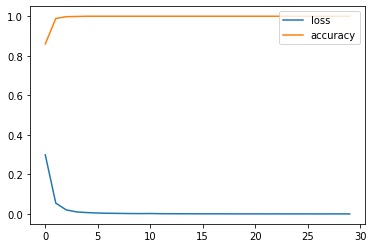

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


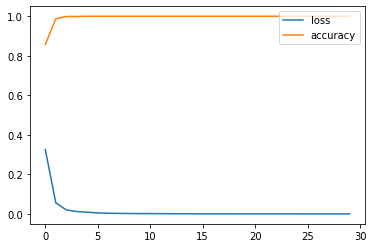

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


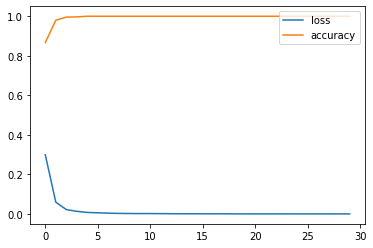

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


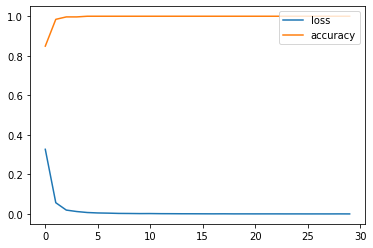

Auc =  0.9444444444444444
Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


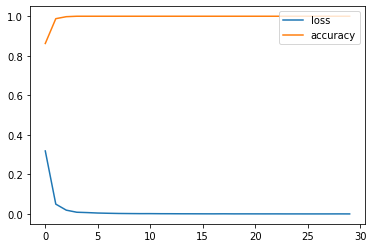

0.9949494949494948

In [11]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.五分类

In [13]:
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;4 OTH
train_Y = np.zeros((992,5))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,240):                                           #Treated CWL 240例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (240,576):                                           #Treated PRT 336例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (576,720):                                           #Treated NUC 144例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (720,816):                                           #Treated OTH 96例
    train_Y[i,4] = 1
    test_Y[i] = 4
for i in range (816,992):                                         #Untreated 176例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

Acc =  0.98
f1_score =  0.98
average_precision =  0.98
recall_score =  0.98


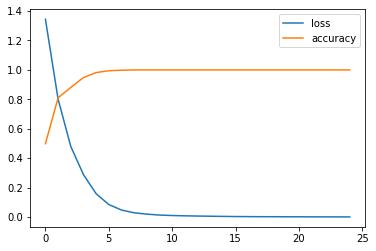

Acc =  0.99
f1_score =  0.99
average_precision =  0.99
recall_score =  0.99


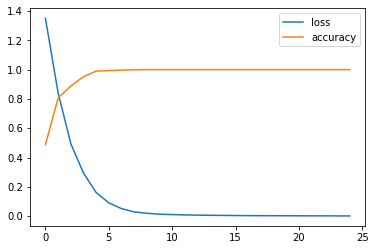

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


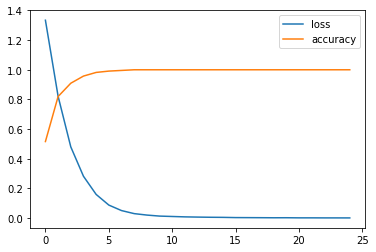

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


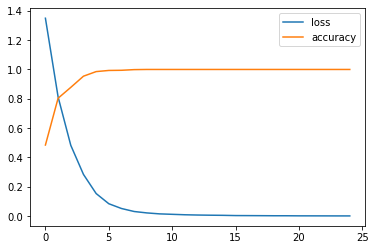

Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


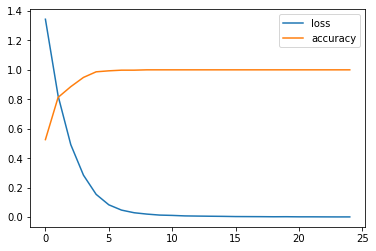

Acc =  0.9696969696969697
f1_score =  0.9696969696969697
average_precision =  0.9696969696969697
recall_score =  0.9696969696969697


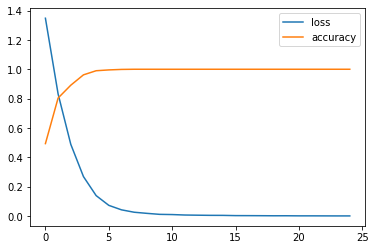

Acc =  0.9696969696969697
f1_score =  0.9696969696969697
average_precision =  0.9696969696969697
recall_score =  0.9696969696969697


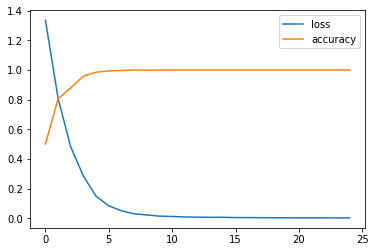

Acc =  0.98989898989899
f1_score =  0.98989898989899
average_precision =  0.98989898989899
recall_score =  0.98989898989899


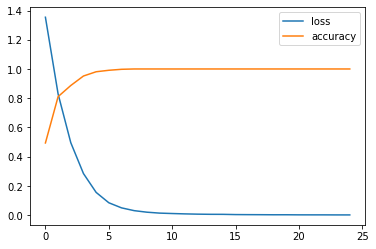

Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


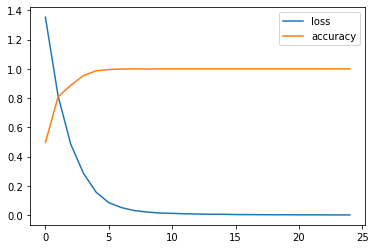

Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


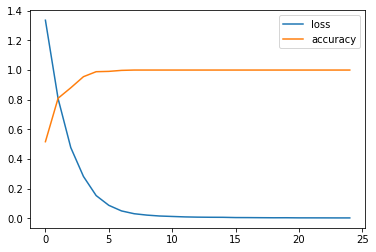

0.9838686868686868

In [18]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64,32],batch_size=64,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred,multi_class='ovo')
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

### 二、Ecoli 外部测试集

#### 1.二分类

In [35]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/peaks_all.csv', t = False)

In [36]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_ecoli_ex.mp')

2024-01-02 19:40:29,832 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 19:40:29,841 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 64/64 [00:00<00:00, 749.87it/s]


2024-01-02 19:40:31,272 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 19:40:31,381 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 19:40:31,397 - INFO - [bidd-aggmap] - Finished


In [24]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/peaks_train.csv', t = False)
train_Y = np.zeros((992,2))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,816):                                           #Treated 816例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (816,992):                                         #Untreated 176例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [31]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 992/992 [00:04<00:00, 220.83it/s] 


In [27]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/peaks_test.csv', t = False)
test_Y = np.zeros(176)                                            #测试标签
for i in range (0,80):                                           #Treated 80例
    test_Y[i] = 0                                                   
for i in range (80,176):                                         #Untreated 96例
    test_Y[i] = 1

ex_y = test_Y.astype(int)

In [28]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 176/176 [00:00<00:00, 362.44it/s]


Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


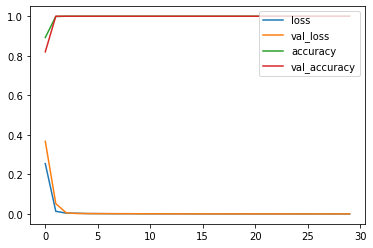

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


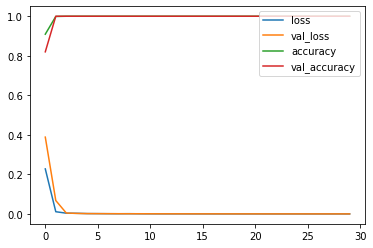

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


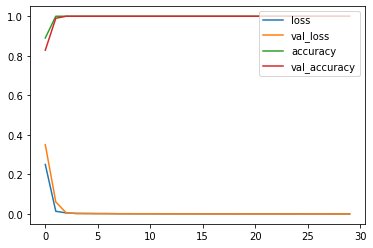

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


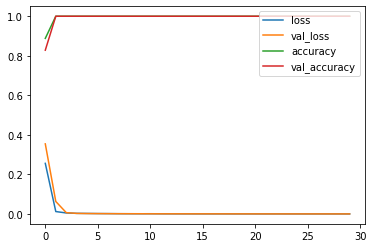

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


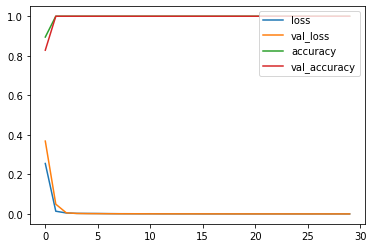

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


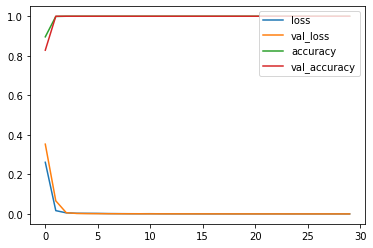

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


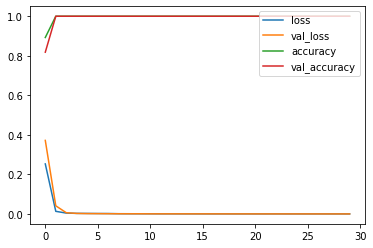

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


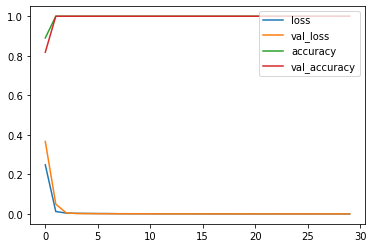

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


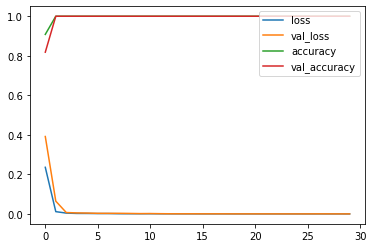

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


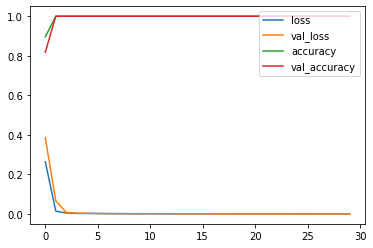

1.0

In [32]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.多分类

In [44]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/MoA/peaks_all.csv', t = False)

In [45]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_ecoli_ex_MoA.mp')

2024-01-02 19:46:17,189 - INFO - [bidd-aggmap] - Calculating distance ...


  1%|          | 8/896 [02:46<06:27,  2.29it/s]
                                               


2024-01-02 19:46:17,209 - INFO - [bidd-aggmap] - the number of process is 16


  1%|          | 8/896 [01:16<06:16,  2.36it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

  0%|          | 4/3570 [00:00<04:12, 14.11it/s]

100%|##########| 3570/3570 [00:00<00:00, 8135.53it/s]


100%|##########| 3570/3570 [00:00<00:00, 791922.22it/s]


  0%|          | 0/85 [00:00<?, ?it/s]

100%|##########| 85/85 [00:00<00:00, 507.27it/s]
                                               


2024-01-02 19:46:18,931 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


  1%|          | 8/896 [02:47<06:27,  2.29it/s]
                                               


2024-01-02 19:46:19,202 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)


  1%|          | 8/896 [02:48<06:27,  2.29it/s]
                                               


2024-01-02 19:46:19,230 - INFO - [bidd-aggmap] - Finished


  1%|          | 8/896 [01:18<06:16,  2.36it/s]

In [38]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/MoA/peaks_train.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((896,4))                                       #将标签以独热编码存起来896
test_Y = np.zeros(896)                                            #用于分层测试的标签
for i in range (0,240):                                           #Treated CWL 240例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (240,576):                                           #Treated PRT 336例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (576,720):                                           #Treated NUC 144例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (720,896):                                          #Untreated 176例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [40]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Ecoli/ex/MoA/peaks_test.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((176,4))                                       #将标签以独热编码存起来176
test_Y = np.zeros(176)                                            #用于分层测试的标签
for i in range (0,16):                                           #Treated CWL 16例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (16,56):                                           #Treated PRT 40例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (56,80):                                           #Treated NUC 24例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (80,176):                                          #Untreated 96例
    train_Y[i,0] = 1
    test_Y[i] = 0

ex_y = test_Y.astype(int)

In [46]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')



  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 1/896 [00:00<03:35,  4.16it/s]

  1%|          | 8/896 [00:03<06:22,  2.32it/s]

  1%|1         | 10/896 [00:03<04:51,  3.04it/s]

  2%|1         | 14/896 [00:03<02:54,  5.06it/s]

  3%|2         | 23/896 [00:03<01:17, 11.23it/s]

  4%|3         | 35/896 [00:03<00:40, 21.39it/s]

  9%|8         | 79/896 [00:03<00:11, 70.35it/s]

100%|##########| 896/896 [00:04<00:00, 218.36it/s]


  0%|          | 0/176 [00:00<?, ?it/s]

100%|##########| 176/176 [00:00<00:00, 937.99it/s]


Acc =  0.9829545454545454
f1_score =  0.9829545454545454
average_precision =  0.9829545454545454
recall_score =  0.9829545454545454


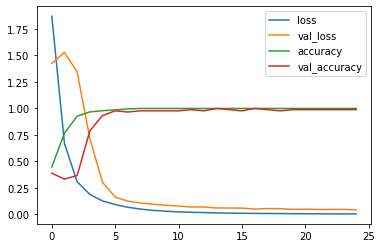

Acc =  0.9886363636363636
f1_score =  0.9886363636363636
average_precision =  0.9886363636363636
recall_score =  0.9886363636363636


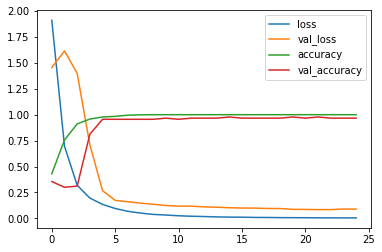

Acc =  0.9772727272727273
f1_score =  0.9772727272727273
average_precision =  0.9772727272727273
recall_score =  0.9772727272727273


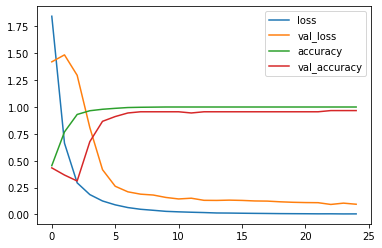

Acc =  0.9886363636363636
f1_score =  0.9886363636363636
average_precision =  0.9886363636363636
recall_score =  0.9886363636363636


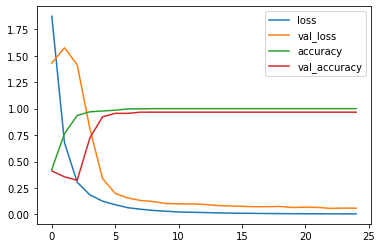

Acc =  0.9829545454545454
f1_score =  0.9829545454545454
average_precision =  0.9829545454545454
recall_score =  0.9829545454545454


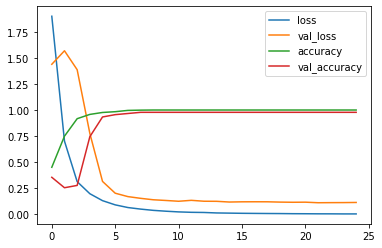

Acc =  0.9886363636363636
f1_score =  0.9886363636363636
average_precision =  0.9886363636363636
recall_score =  0.9886363636363636


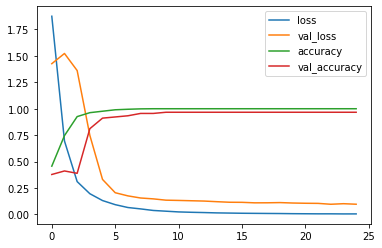

Acc =  0.9772727272727273
f1_score =  0.9772727272727273
average_precision =  0.9772727272727273
recall_score =  0.9772727272727273


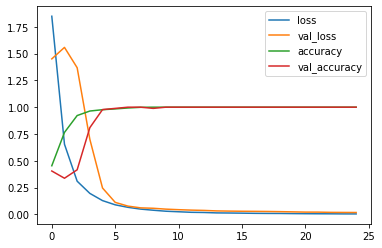

Acc =  0.9886363636363636
f1_score =  0.9886363636363636
average_precision =  0.9886363636363636
recall_score =  0.9886363636363636


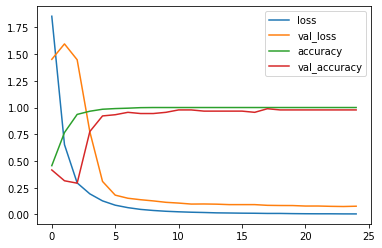

Acc =  0.9886363636363636
f1_score =  0.9886363636363636
average_precision =  0.9886363636363636
recall_score =  0.9886363636363636


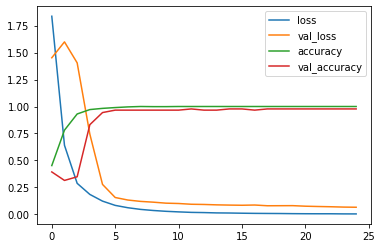

Acc =  0.9829545454545454
f1_score =  0.9829545454545454
average_precision =  0.9829545454545454
recall_score =  0.9829545454545454


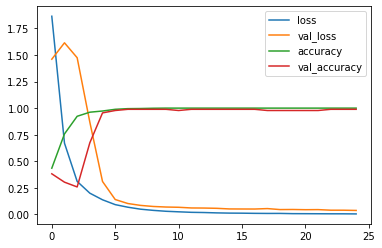

0.9846590909090909

In [48]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=128,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

### 三、Sau（10μm）内部交叉验证

#### 1.二分类

In [51]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/peaks_0.5.csv', t = False)
train_Y = np.zeros((992,2))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,816):                                           #Treated 816例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (816,992):                                         #Untreated 176例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [52]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau10_0.5.mp')

2024-01-02 20:14:02,439 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [29:01<06:16,  2.36it/s]


2024-01-02 20:14:02,453 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 79/79 [00:00<00:00, 744.64it/s]



2024-01-02 20:14:04,060 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [29:03<06:16,  2.36it/s]


2024-01-02 20:14:04,198 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [29:03<06:16,  2.36it/s]


2024-01-02 20:14:04,221 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [29:03<06:16,  2.36it/s]

In [53]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 992/992 [00:04<00:00, 239.56it/s]


Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


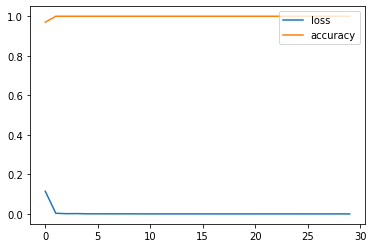

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


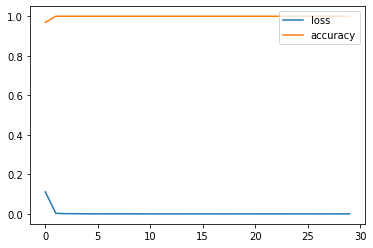

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


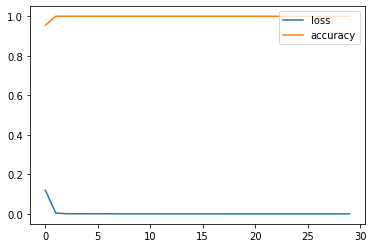

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


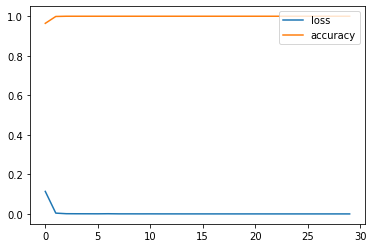

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


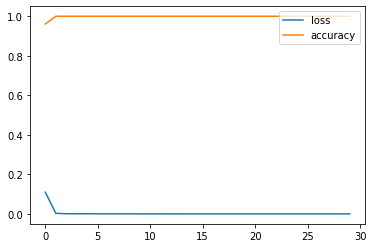

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


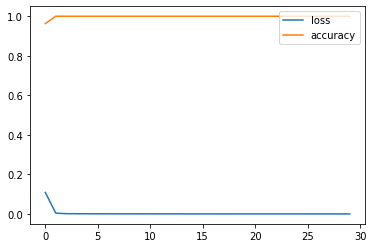

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


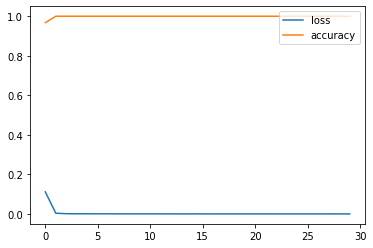

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


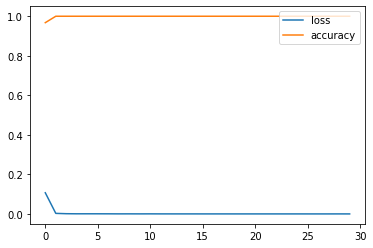

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


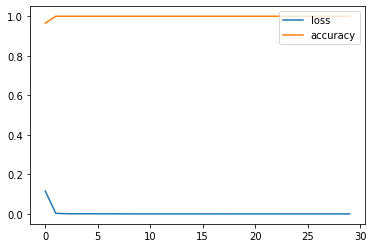

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


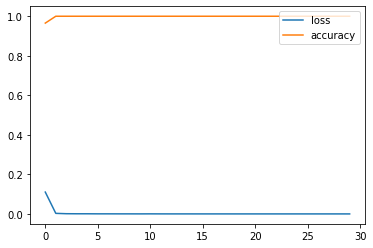

1.0

In [54]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.多分类

In [56]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/peaks_0.5_5.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;4 OTH
train_Y = np.zeros((992,5))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,240):                                           #Treated CWL 240例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (240,576):                                           #Treated PRT 336例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (576,720):                                           #Treated NUC 144例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (720,816):                                           #Treated OTH 96例
    train_Y[i,4] = 1
    test_Y[i] = 4
for i in range (816,992):                                           #Untreated 176例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [57]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau10_0.5_5.mp')

2024-01-02 20:18:12,249 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [33:11<06:16,  2.36it/s]


2024-01-02 20:18:12,263 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 110/110 [00:00<00:00, 468.50it/s]



2024-01-02 20:18:14,706 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [33:14<06:16,  2.36it/s]


2024-01-02 20:18:15,271 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [33:14<06:16,  2.36it/s]


2024-01-02 20:18:15,332 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [33:14<06:16,  2.36it/s]

In [58]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 992/992 [00:04<00:00, 233.46it/s] 


Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


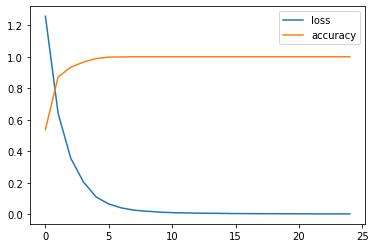

Acc =  0.99
f1_score =  0.99
average_precision =  0.99
recall_score =  0.99


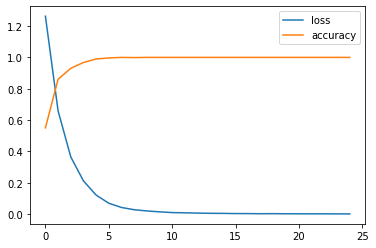

Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


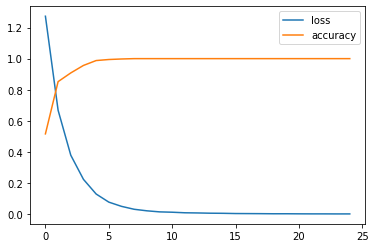

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


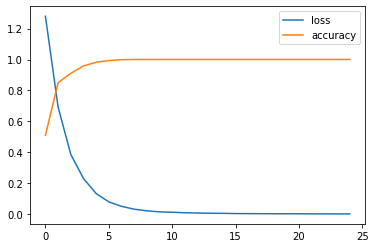

Acc =  0.98989898989899
f1_score =  0.98989898989899
average_precision =  0.98989898989899
recall_score =  0.98989898989899


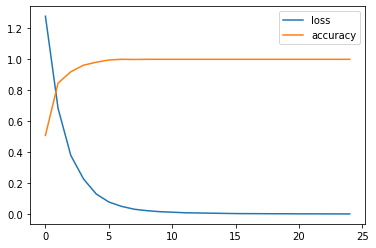

Acc =  0.9696969696969697
f1_score =  0.9696969696969697
average_precision =  0.9696969696969697
recall_score =  0.9696969696969697


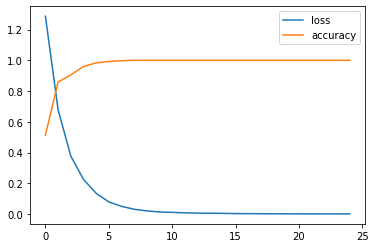

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


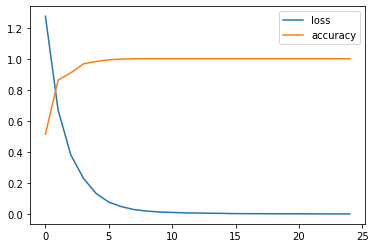

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


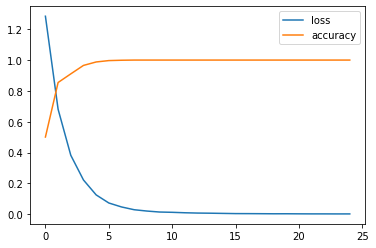

Acc =  0.98989898989899
f1_score =  0.98989898989899
average_precision =  0.98989898989899
recall_score =  0.98989898989899


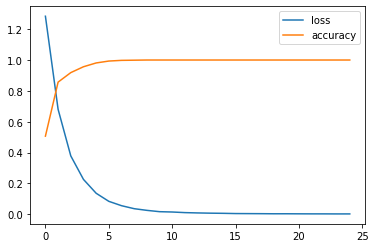

Acc =  0.9797979797979798
f1_score =  0.9797979797979798
average_precision =  0.9797979797979798
recall_score =  0.9797979797979798


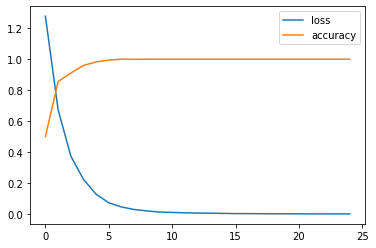

0.9899090909090908

In [59]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64,32],batch_size=64,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred,multi_class='ovo')
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

### 四、Sau（μm）外部测试集

#### 1.二分类

In [60]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/peaks_all.csv', t = False)

In [61]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau10_ex.mp')

2024-01-02 20:30:46,354 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [45:45<06:16,  2.36it/s]


2024-01-02 20:30:46,372 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 71/71 [00:00<00:00, 721.31it/s]



2024-01-02 20:30:47,893 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [45:47<06:16,  2.36it/s]


2024-01-02 20:30:48,017 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [45:47<06:16,  2.36it/s]


2024-01-02 20:30:48,039 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [45:47<06:16,  2.36it/s]

In [62]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/peaks_train.csv', t = False)
train_Y = np.zeros((992,2))                                       #将标签以独热编码存起来992
test_Y = np.zeros(992)                                            #用于分层测试的标签
for i in range (0,816):                                           #Treated 816例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (816,992):                                         #Untreated 176例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [64]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/peaks_test.csv', t = False)
test_Y = np.zeros(160)                                            #测试标签
for i in range (0,80):                                           #Treated 80例
    test_Y[i] = 0                                                   
for i in range (80,160):                                         #Untreated 80例
    test_Y[i] = 1

ex_y = test_Y.astype(int)

In [65]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 160/160 [00:00<00:00, 688.97it/s]


Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


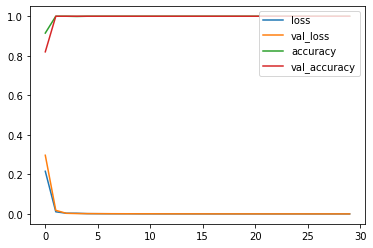

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


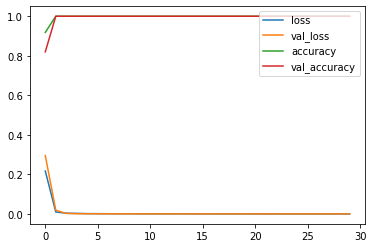

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


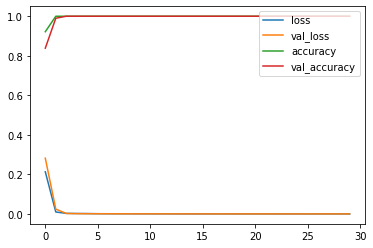

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


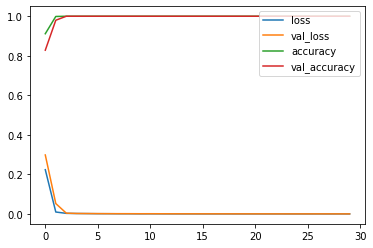

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


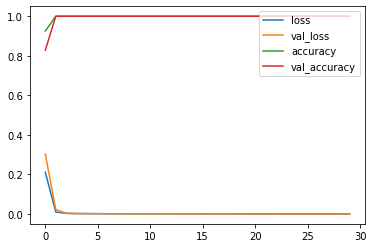

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


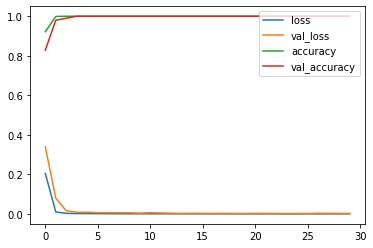

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


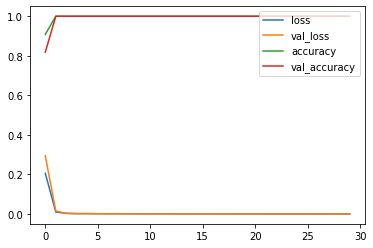

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


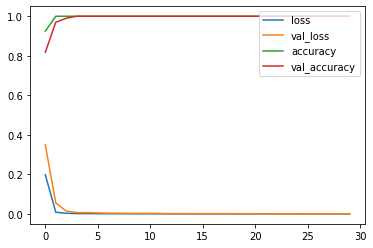

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


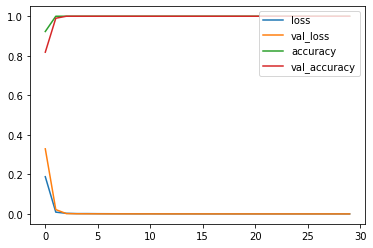

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


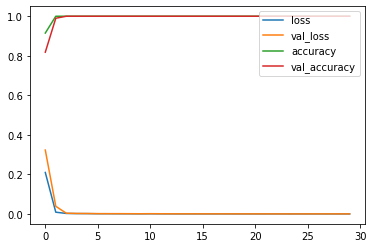

1.0

In [66]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.多分类

In [67]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/MoA/peaks_all.csv', t = False)

In [68]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau10_ex_MoA.mp')

2024-01-02 20:35:16,871 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [50:16<06:16,  2.36it/s]


2024-01-02 20:35:16,885 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 87/87 [00:00<00:00, 537.35it/s]



2024-01-02 20:35:18,601 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [50:18<06:16,  2.36it/s]


2024-01-02 20:35:18,832 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [50:18<06:16,  2.36it/s]


2024-01-02 20:35:18,851 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [50:18<06:16,  2.36it/s]

In [69]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/MoA/peaks_train.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((896,4))                                       #将标签以独热编码存起来896
test_Y = np.zeros(896)                                            #用于分层测试的标签
for i in range (0,240):                                           #Treated CWL 240例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (240,576):                                           #Treated PRT 336例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (576,720):                                           #Treated NUC 144例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (720,896):                                          #Untreated 176例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [70]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/10/ex/MoA/peaks_test.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((336,4))                                       #将标签以独热编码存起来336
test_Y = np.zeros(336)                                            #用于分层测试的标签
for i in range (0,16):                                           #Treated CWL 16例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (16,56):                                           #Treated PRT 40例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (56,80):                                           #Treated NUC 24例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (80,336):                                          #Untreated 256例
    train_Y[i,0] = 1
    test_Y[i] = 0

ex_y = test_Y.astype(int)

In [71]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 336/336 [00:00<00:00, 1355.67it/s]


Acc =  0.9642857142857143
f1_score =  0.9642857142857143
average_precision =  0.9642857142857143
recall_score =  0.9642857142857143


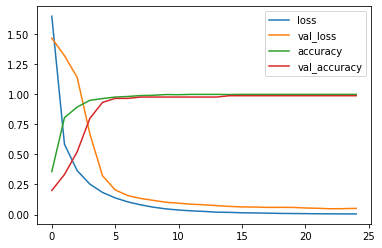

Acc =  0.9672619047619048
f1_score =  0.9672619047619048
average_precision =  0.9672619047619048
recall_score =  0.9672619047619048


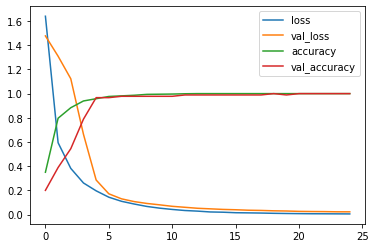

Acc =  0.9732142857142857
f1_score =  0.9732142857142857
average_precision =  0.9732142857142857
recall_score =  0.9732142857142857


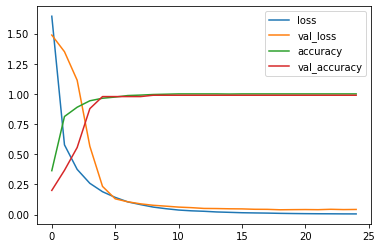

Acc =  0.9761904761904762
f1_score =  0.9761904761904762
average_precision =  0.9761904761904762
recall_score =  0.9761904761904762


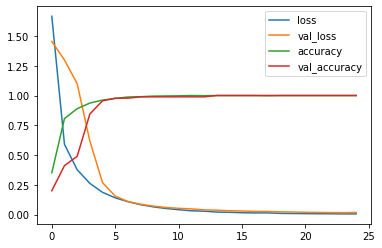

Acc =  0.9613095238095238
f1_score =  0.9613095238095238
average_precision =  0.9613095238095238
recall_score =  0.9613095238095238


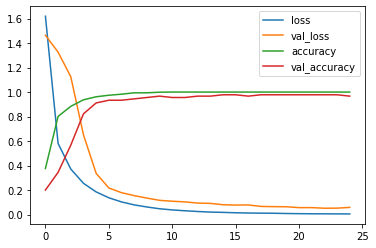

Acc =  0.9642857142857143
f1_score =  0.9642857142857143
average_precision =  0.9642857142857143
recall_score =  0.9642857142857143


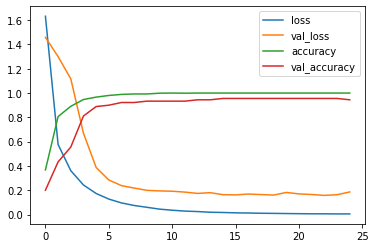

Acc =  0.9761904761904762
f1_score =  0.9761904761904762
average_precision =  0.9761904761904762
recall_score =  0.9761904761904762


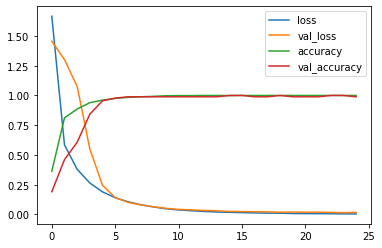

Acc =  0.9791666666666666
f1_score =  0.9791666666666666
average_precision =  0.9791666666666666
recall_score =  0.9791666666666666


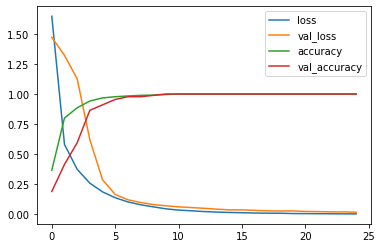

Acc =  0.9821428571428571
f1_score =  0.9821428571428571
average_precision =  0.9821428571428571
recall_score =  0.9821428571428571


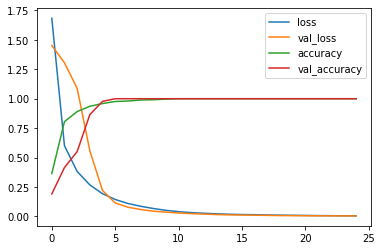

Acc =  0.9821428571428571
f1_score =  0.9821428571428571
average_precision =  0.9821428571428571
recall_score =  0.9821428571428571


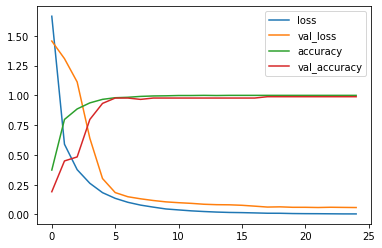

0.9726190476190478

In [74]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,32],batch_size=128,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

### 五、Sau（1μm）内部交叉验证

#### 1.二分类

In [77]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/peaks_0.5.csv', t = False)
train_Y = np.zeros((712,2))                                       #将标签以独热编码存起来712
test_Y = np.zeros(712)                                            #用于分层测试的标签
for i in range (0,376):                                           #Treated 376例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (376,712):                                         #Untreated 336例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [78]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau1_0.5.mp')

2024-01-02 20:55:22,427 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [1:10:21<06:16,  2.36it/s]


2024-01-02 20:55:22,441 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 60/60 [00:00<00:00, 527.63it/s]



2024-01-02 20:55:23,971 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [1:10:23<06:16,  2.36it/s]


2024-01-02 20:55:24,152 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [1:10:23<06:16,  2.36it/s]


2024-01-02 20:55:24,173 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [1:10:23<06:16,  2.36it/s]

In [79]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 712/712 [00:04<00:00, 173.96it/s]


Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


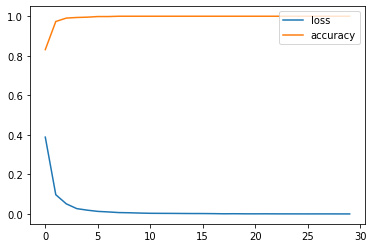

Auc =  0.9852941176470589
Acc =  0.9861111111111112
f1_score =  0.9861111111111112
average_precision =  0.9861111111111112
recall_score =  0.9861111111111112


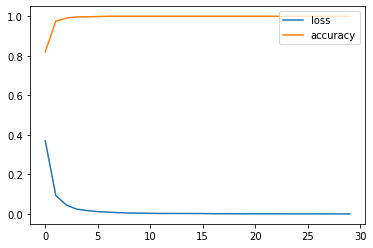

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


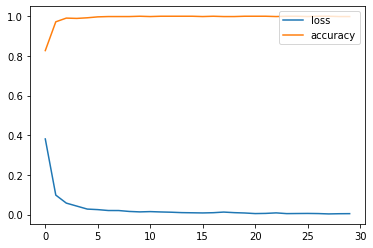

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


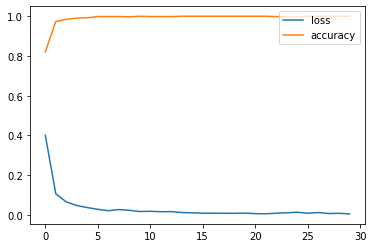

Auc =  0.9848484848484849
Acc =  0.9859154929577465
f1_score =  0.9859154929577465
average_precision =  0.9859154929577465
recall_score =  0.9859154929577465


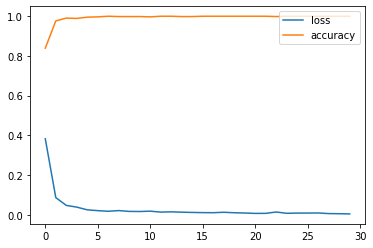

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


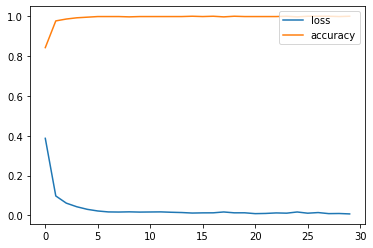

Auc =  0.9717806041335455
Acc =  0.971830985915493
f1_score =  0.971830985915493
average_precision =  0.971830985915493
recall_score =  0.971830985915493


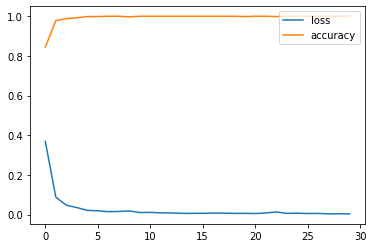

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


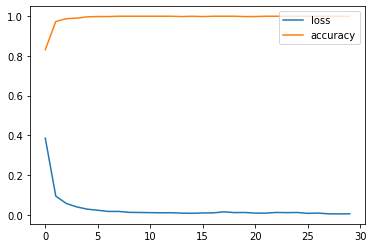

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


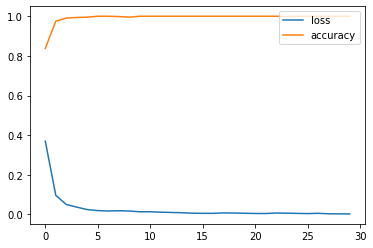

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


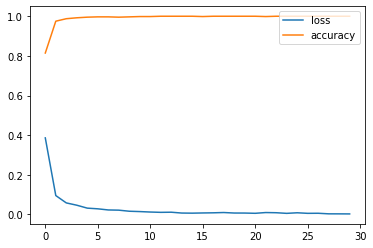

0.9943857589984351

In [80]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

In [ ]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.多分类

In [81]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/peaks_0.5_5.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;4 OTH
train_Y = np.zeros((712,5))                                       #将标签以独热编码存起来712
test_Y = np.zeros(712)                                            #用于分层测试的标签
for i in range (0,112):                                           #Treated CWL 112例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (112,288):                                           #Treated PRT 176例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (288,352):                                           #Treated NUC 64例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (352,376):                                           #Treated OTH 24例
    train_Y[i,4] = 1
    test_Y[i] = 4
for i in range (376,712):                                           #Untreated 336例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [82]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau1_0.5_5.mp')

2024-01-02 21:02:38,428 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [1:17:37<06:16,  2.36it/s]


2024-01-02 21:02:38,446 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 216/216 [00:00<00:00, 605.03it/s]



2024-01-02 21:02:41,132 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [1:17:40<06:16,  2.36it/s]


2024-01-02 21:02:41,975 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [1:17:41<06:16,  2.36it/s]


2024-01-02 21:02:42,003 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [1:17:41<06:16,  2.36it/s]

In [83]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 712/712 [00:04<00:00, 167.32it/s]


Acc =  0.9861111111111112
f1_score =  0.9861111111111112
average_precision =  0.9861111111111112
recall_score =  0.9861111111111112


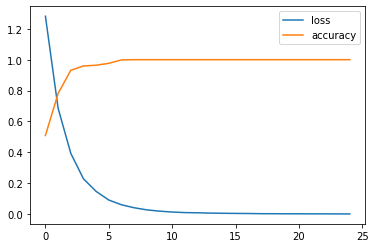

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


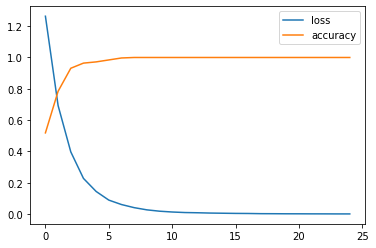

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


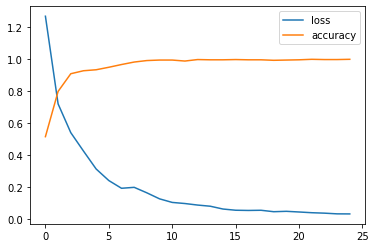

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


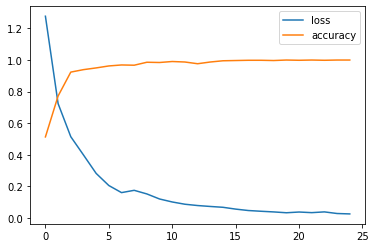

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


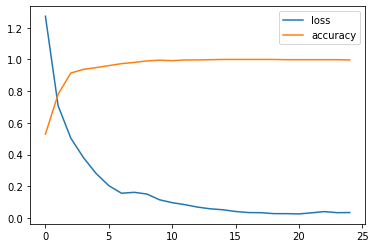

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


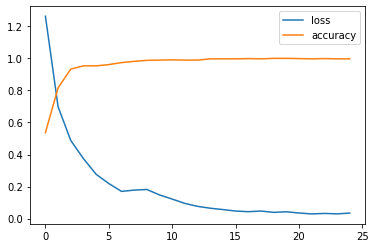

Acc =  0.9859154929577465
f1_score =  0.9859154929577465
average_precision =  0.9859154929577465
recall_score =  0.9859154929577465


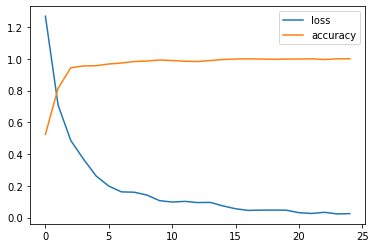

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


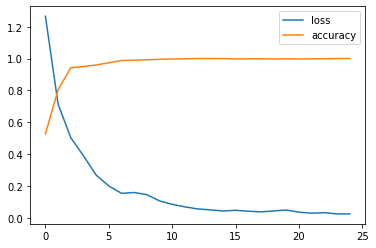

Acc =  0.9859154929577465
f1_score =  0.9859154929577465
average_precision =  0.9859154929577465
recall_score =  0.9859154929577465


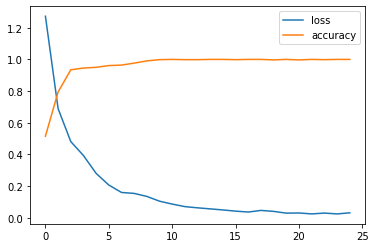

Acc =  0.9859154929577465
f1_score =  0.9859154929577465
average_precision =  0.9859154929577465
recall_score =  0.9859154929577465


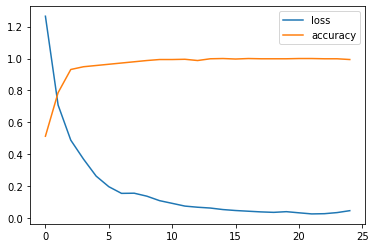

0.9943857589984348

In [84]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64,32],batch_size=64,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred,multi_class='ovo')
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

### 六、Sau（1μm）外部测试集

#### 1.二分类

In [86]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/bin/peaks_all.csv', t = False)

In [87]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau1_ex.mp')

2024-01-02 21:14:29,206 - INFO - [bidd-aggmap] - Calculating distance ...



  1%|          | 8/896 [1:29:28<06:16,  2.36it/s]


2024-01-02 21:14:29,220 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 60/60 [00:00<00:00, 487.73it/s]



2024-01-02 21:14:30,783 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...



  1%|          | 8/896 [1:29:30<06:16,  2.36it/s]


2024-01-02 21:14:30,921 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)



  1%|          | 8/896 [1:29:30<06:16,  2.36it/s]


2024-01-02 21:14:30,943 - INFO - [bidd-aggmap] - Finished



  1%|          | 8/896 [1:29:30<06:16,  2.36it/s]

In [88]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/bin/peaks_train.csv', t = False)
train_Y = np.zeros((712,2))                                       #将标签以独热编码存起来712
test_Y = np.zeros(712)                                            #用于分层测试的标签
for i in range (0,376):                                           #Treated 376例
    train_Y[i,0] = 1
    test_Y[i] = 0                                                   
for i in range (376,712):                                         #Untreated 336例
    train_Y[i,1] = 1
    test_Y[i] = 1

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [89]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/bin/peaks_test.csv', t = False)
test_Y = np.zeros(48)                                            #测试标签
for i in range (0,40):                                           #Treated 40例
    test_Y[i] = 0                                                   
for i in range (40,48):                                         #Untreated 8例
    test_Y[i] = 1

ex_y = test_Y.astype(int)

In [90]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 48/48 [00:00<00:00, 393.43it/s]


Auc =  0.8125
Acc =  0.9375
f1_score =  0.9375
average_precision =  0.9375
recall_score =  0.9375


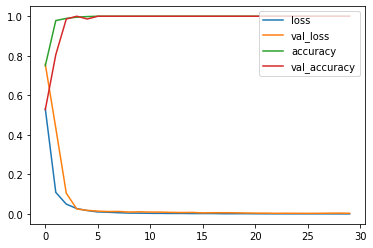

Auc =  0.8125
Acc =  0.9375
f1_score =  0.9375
average_precision =  0.9375
recall_score =  0.9375


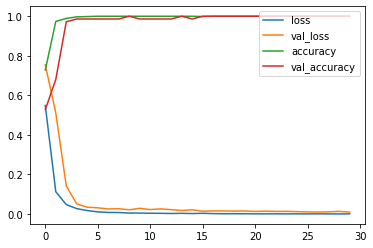

Auc =  0.9
Acc =  0.9166666666666666
f1_score =  0.9166666666666666
average_precision =  0.9166666666666666
recall_score =  0.9166666666666666


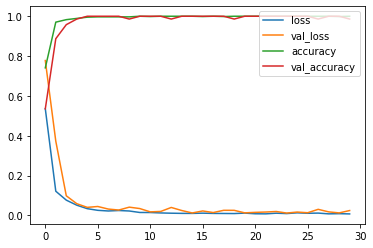

Auc =  0.75
Acc =  0.9166666666666666
f1_score =  0.9166666666666666
average_precision =  0.9166666666666666
recall_score =  0.9166666666666666


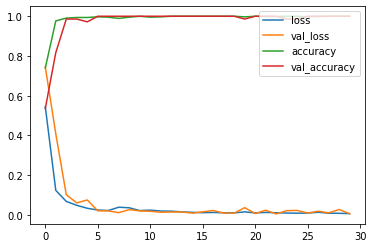

Auc =  0.6875
Acc =  0.8958333333333334
f1_score =  0.8958333333333334
average_precision =  0.8958333333333334
recall_score =  0.8958333333333334


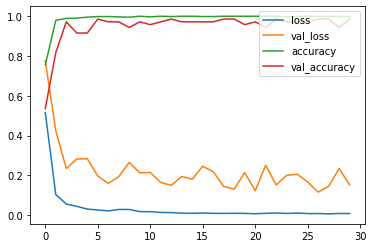

Auc =  0.7999999999999999
Acc =  0.9166666666666666
f1_score =  0.9166666666666666
average_precision =  0.9166666666666666
recall_score =  0.9166666666666666


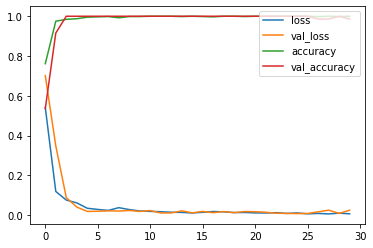

Auc =  0.75
Acc =  0.9166666666666666
f1_score =  0.9166666666666666
average_precision =  0.9166666666666666
recall_score =  0.9166666666666666


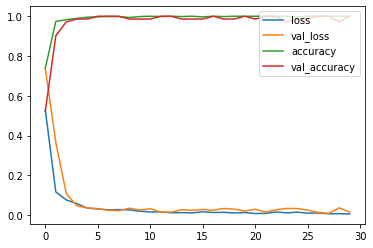

Auc =  0.9375
Acc =  0.9791666666666666
f1_score =  0.9791666666666666
average_precision =  0.9791666666666666
recall_score =  0.9791666666666666


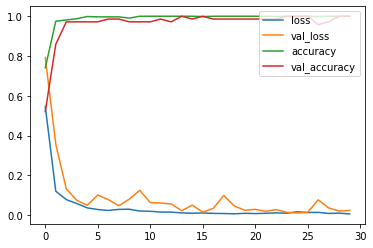

Auc =  0.7374999999999999
Acc =  0.8958333333333334
f1_score =  0.8958333333333334
average_precision =  0.8958333333333334
recall_score =  0.8958333333333334


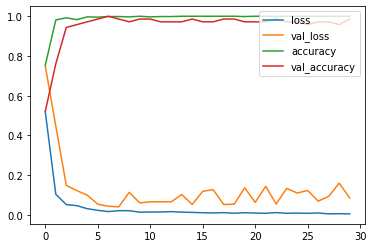

Auc =  0.9375
Acc =  0.9791666666666666
f1_score =  0.9791666666666666
average_precision =  0.9791666666666666
recall_score =  0.9791666666666666


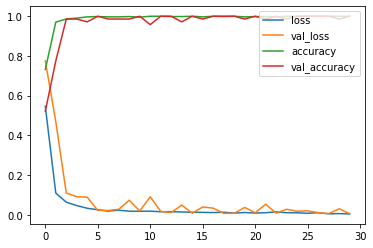

0.9291666666666666

In [104]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

Auc =  0.75
Acc =  0.9166666666666666
f1_score =  0.9166666666666666
average_precision =  0.9166666666666666
recall_score =  0.9166666666666666


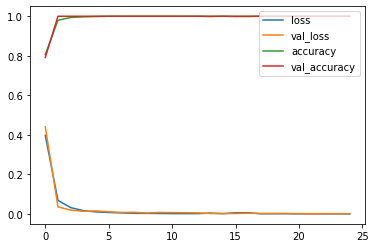

Auc =  0.875
Acc =  0.9583333333333334
f1_score =  0.9583333333333334
average_precision =  0.9583333333333334
recall_score =  0.9583333333333334


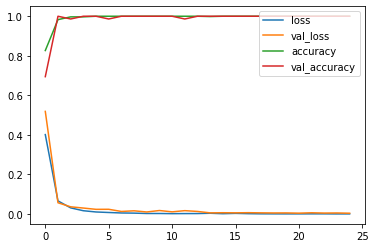

Auc =  0.8625
Acc =  0.7708333333333334
f1_score =  0.7708333333333333
average_precision =  0.7708333333333334
recall_score =  0.7708333333333334


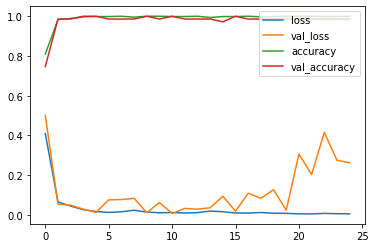

Auc =  0.8375
Acc =  0.8958333333333334
f1_score =  0.8958333333333334
average_precision =  0.8958333333333334
recall_score =  0.8958333333333334


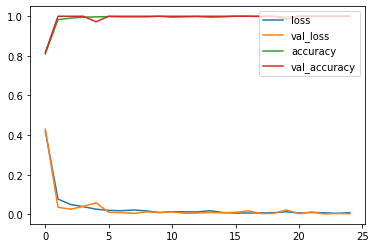

Auc =  0.625
Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


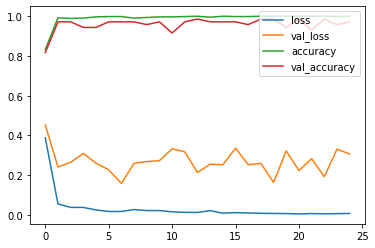

Auc =  0.7249999999999999
Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


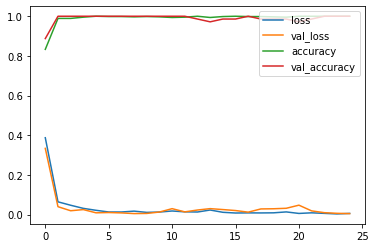

Auc =  0.9874999999999999
Acc =  0.9791666666666666
f1_score =  0.9791666666666666
average_precision =  0.9791666666666666
recall_score =  0.9791666666666666


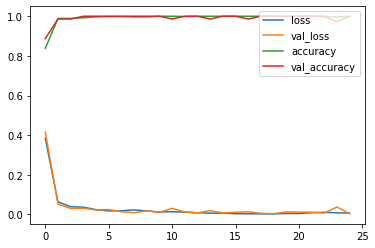

Auc =  0.6749999999999999
Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


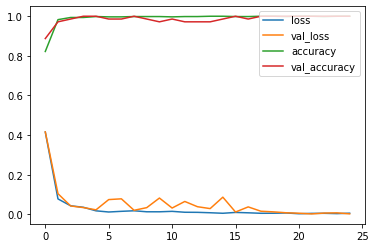

Auc =  0.6875
Acc =  0.8958333333333334
f1_score =  0.8958333333333334
average_precision =  0.8958333333333334
recall_score =  0.8958333333333334


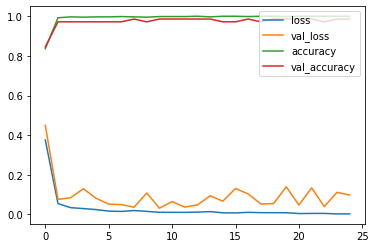

Auc =  0.625
Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


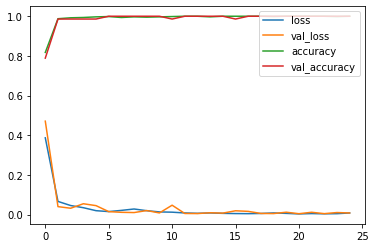

0.8916666666666668

In [114]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=32,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y, X_val=val_X, y_val=val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(ex_y, y_pred)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10

#### 2.多分类

In [115]:
dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/MoA/peaks_all.csv', t = False)

In [116]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_sau1_ex_MoA.mp')

2024-01-02 22:12:32,814 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 22:12:32,824 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 147/147 [00:00<00:00, 288.77it/s]


2024-01-02 22:12:35,203 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 22:12:35,782 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 22:12:35,803 - INFO - [bidd-aggmap] - Finished


In [117]:
train_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/MoA/peaks_train.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((688,4))                                       #将标签以独热编码存起来688
test_Y = np.zeros(688)                                            #用于分层测试的标签
for i in range (0,112):                                           #Treated CWL 112例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (112,288):                                           #Treated PRT 176例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (288,352):                                           #Treated NUC 64例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (352,688):                                          #Untreated 336例
    train_Y[i,0] = 1
    test_Y[i] = 0

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [118]:
test_dfx = LoadMSData(root_path = root_path, data_path = 'data10/Sau/1/ex/MoA/peaks_test.csv', t = False)
#MoA labels loading
#0 Untreated;1 CWL;2 PRT;3 NUC;
train_Y = np.zeros((48,4))                                       #将标签以独热编码存起来48
test_Y = np.zeros(48)                                            #用于分层测试的标签
for i in range (0,8):                                           #Treated CWL 8例
    train_Y[i,1] = 1
    test_Y[i] = 1  
for i in range (8,32):                                           #Treated PRT 24例
    train_Y[i,2] = 1
    test_Y[i] = 2 
for i in range (32,40):                                           #Treated NUC 8例
    train_Y[i,3] = 1
    test_Y[i] = 3 
for i in range (40,48):                                          #Untreated 8例
    train_Y[i,0] = 1
    test_Y[i] = 0

ex_y = test_Y.astype(int)

In [119]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(train_dfx.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(test_dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 48/48 [00:00<00:00, 528.67it/s]


Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


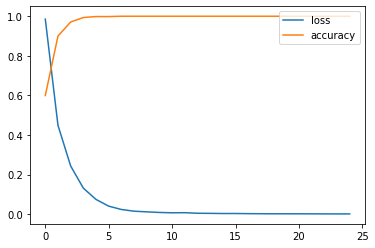

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


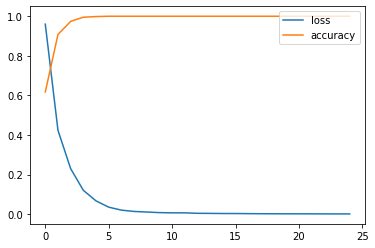

Acc =  0.9855072463768116
f1_score =  0.9855072463768116
average_precision =  0.9855072463768116
recall_score =  0.9855072463768116


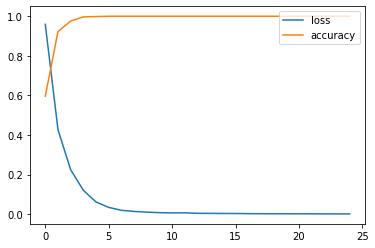

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


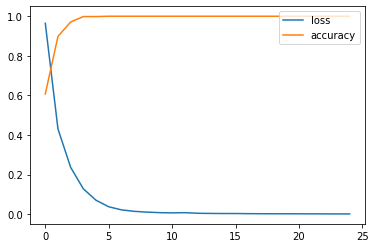

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


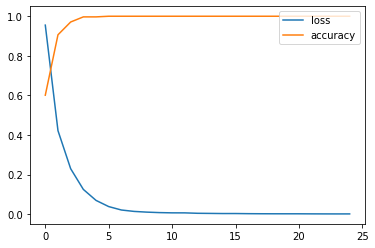

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


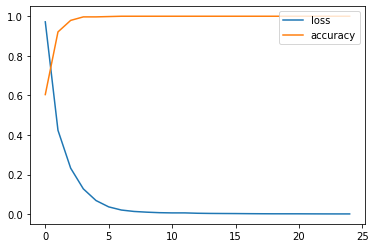

Acc =  0.9855072463768116
f1_score =  0.9855072463768116
average_precision =  0.9855072463768116
recall_score =  0.9855072463768116


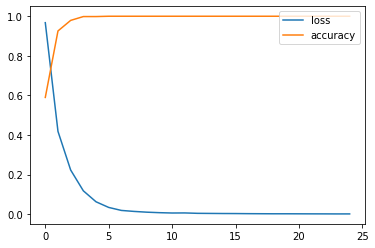

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


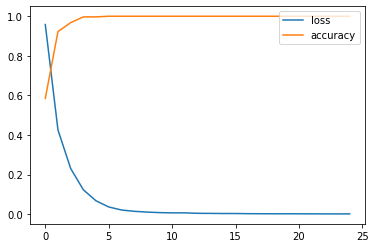

Acc =  0.9852941176470589
f1_score =  0.9852941176470589
average_precision =  0.9852941176470589
recall_score =  0.9852941176470589


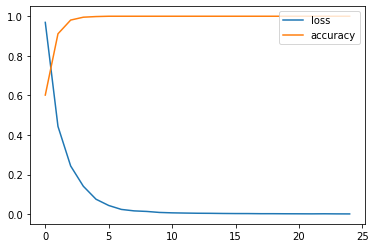

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


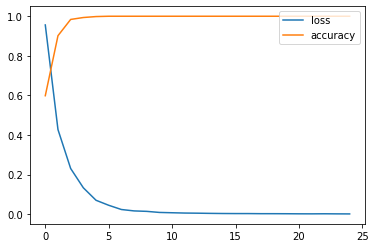

0.9956308610400683

In [120]:
#三核 十折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64,32],batch_size=64,epochs=25,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred,multi_class='ovo')
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 10